In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, execute, IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_state_qsphere, plot_histogram
from qiskit.tools.visualization import circuit_drawer 
from qiskit.tools.jupyter import *
from tqdm import tqdm

In [2]:
images = np.load('data/images.npy')

In [3]:
print(images.shape)

(2000, 28, 28)


In [4]:
labels = np.load('data/labels.npy')
print(labels.shape)

(2000,)


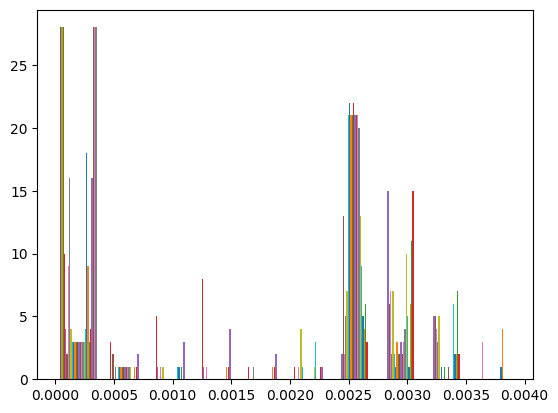

In [5]:
i = np.random.randint(2000)
plt.hist(images[i])
plt.show()

In [6]:
img = np.random.rand(2,2)

In [17]:
def encode(data):
    data = data * 255 / data.max()
    data = data.astype(int)
    data = pooling(data)
    data = data.astype(int)
    n = 8
    q = 1
    ac = 7
    num_qubits = n+q+ac #8 qubits for pixels and 6 qubits for data 
    qc_image = QuantumCircuit(num_qubits, n+q) 

    for i in range(n):
        qc_image.h(i)


    # Add the CNOT gates 
    for idx , px in np.ndenumerate(data):
        if px > 15: 
            qc_image = apply_x(qc_image,*idx)
            qc_image = apply_tofolli(qc_image,n,n+q,n, np.pi * px / (2*240))
            qc_image = apply_x(qc_image,*idx)

    # #run circuit in backend and get the state vector 
    # backend = BasicAer.get_backend('statevector_simulator')
    # result = execute(qc_image, backend=backend).result() 
    # output = result.get_statevector(qc_image) 

    for i in range(n+q):
        qc_image.measure(i,i)

    return qc_image


def bin_rep(x, n=8):
    t = "{0:b}".format(x)
    if len(t) < n:
        t = '0'*(n-len(t)) + t
    elif len(t) > n:
        t = t[len(t)-n:]
    return t

def tofolli(qc: QuantumCircuit,x,y,t):
    # qc.barrier()
    qc.h(t)
    qc.cx(y,t)
    qc.tdg(t)
    qc.cx(x,t)
    qc.t(t)
    qc.cx(y,t)
    qc.tdg(t)
    qc.cx(x,t)
    qc.t(y)
    qc.t(t)
    qc.cx(x,y)
    qc.h(t)
    qc.t(x)
    qc.tdg(y)
    qc.cx(x,y)
    # qc.barrier()
    return qc

def apply_tofolli(qc, n, anc, target, theta):
    anc_st = anc
    # qc.barrier()
    for i in range(n):
        if i == 0:
            qc = tofolli(qc,i,i+1,anc)
        elif i == 1:
            ...
        else:
            qc = tofolli(qc,i, anc_st, anc_st+1)
            anc_st += 1

    qc.cry(theta, anc_st, target)
    anc_st -= 1

    for i in reversed(range(n)):
        if i == 0:
            qc = tofolli(qc,i,i+1,anc)
        elif i == 1:
            pass
        else:
            qc = tofolli(qc,i, anc_st, anc_st+1)
            anc_st -= 1
    
    # qc.barrier()

    return qc

def apply_x(qc, x,y):
    x = bin_rep(x,4)
    y = bin_rep(y,4)
    t = x+y
    # qc.barrier()
    for i, v in enumerate(t):
        if v == '1':
            qc.x(i)
    # qc.barrier()
    return qc


In [8]:
qc_image = encrypt(images[0])
# qc_image.draw() 
# circuit_drawer(qc_image, filename='./qc01', output='mpl') 
# circuit_drawer(qc_image, filename='./qc02', output='text')


In [14]:
def decode(hist):
    def bin_rep(x, n=8):
        t = "{0:b}".format(x)
        if len(t) < n:
            t = '0'*(n-len(t)) + t
        elif len(t) > n:
            t = t[len(t)-n:]
        return t
    
    n = 16
    img = np.zeros((n,n))
    
    for i in range(n):
        for j in range(n):
            st =  bin_rep(i,4) + bin_rep(j,4) 
            st = st[::-1]
            st0 = '0' + st
            st1 = '1' + st
            if st0 in hist and st1 in hist:
                c0, c1 = hist[st0], hist[st1]
                t = c0+c1
                c0,c1 = c0/t, c1/t
                img[n-i-1][j] = math.acos(c0-c1)
            else:
                img[n-i-1][j] = 0
            
    img = img * 2 * 240 / np.pi
    img = img[:-2,2:]
    for i in range(14):
        img[i] = np.flip(img[i])
    return double(img)


def double(img):
    new_img = np.zeros((28,28))
    x,y = 0,0
    for (i,j),v in np.ndenumerate(img):
        new_img[2*i, 2*j] = v
        new_img[2*i+1, 2*j] = v
        new_img[2*i, 2*j+1] = v
        new_img[2*i+1, 2*j+1] = v
    return new_img


In [18]:
qc = encrypt(images[0])
print("Depth: " ,qc.depth())
print("Ops: ",qc.count_ops())

Depth:  18444
Ops:  OrderedDict([('cx', 10920), ('t', 7280), ('tdg', 5460), ('h', 3648), ('x', 936), ('cry', 130), ('measure', 9)])


In [19]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 1_000_000
results = execute(qc, backend=backend, shots=shots).result()
answer = results.get_counts()

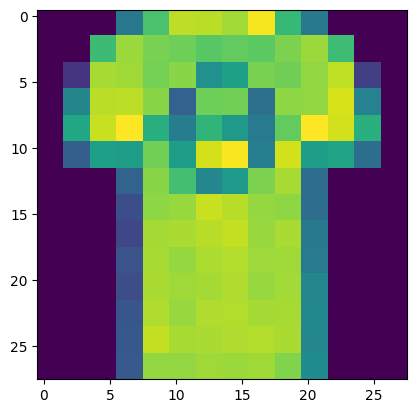

In [20]:
img = decode(answer)
plt.imshow(img)

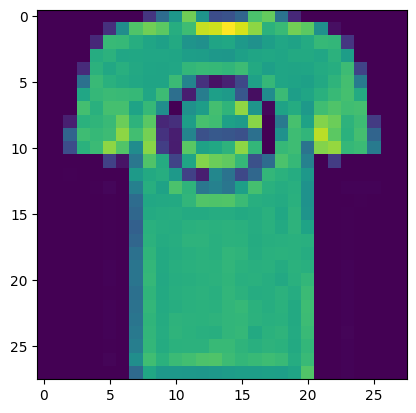

In [16]:
data = images[0]
plt.imshow(data)